In [2]:
import ccxt
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.base import clone 
from sklearn.feature_selection import VarianceThreshold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from functools import partial
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice, money_flow_index

In [3]:
'''
symbol: Stock
time_interval: data time frequency
start_date: datetime in which to obtain data for
'''

def create_raw_stock_dataset(symbol, time_interval, start_date):
    exchange = ccxt.binance()
    since = int(start_date.timestamp() * 1000)
    ohlcv = exchange.fetch_ohlcv(symbol, time_interval, since=since, limit = 10000)
    data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

    return data
    

In [4]:
symbol = 'BTC/USDT'
time_interval = '1d'
start_date = datetime(2023, 1, 1)  
df = create_raw_stock_dataset(symbol, time_interval, start_date)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  824 non-null    datetime64[ns]
 1   open       824 non-null    float64       
 2   high       824 non-null    float64       
 3   low        824 non-null    float64       
 4   close      824 non-null    float64       
 5   volume     824 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 38.8 KB
None


In [5]:
test_start_date = '2025-03-01'
cutoff_date = '2025-03-31'

train = df[df['timestamp'] < test_start_date]
test = df[(df['timestamp'] >= test_start_date) & (df['timestamp'] <= cutoff_date)]
print(train.head())
print(test.tail())


   timestamp      open      high       low     close        volume
0 2023-01-01  16541.77  16628.00  16499.01  16616.75   96925.41374
1 2023-01-02  16617.17  16799.23  16548.70  16672.87  121888.57191
2 2023-01-03  16672.78  16778.40  16605.28  16675.18  159541.53733
3 2023-01-04  16675.65  16991.87  16652.66  16850.36  220362.18862
4 2023-01-05  16850.36  16879.82  16753.00  16831.85  163473.56641
     timestamp      open      high       low     close       volume
816 2025-03-27  86909.17  87756.39  85800.00  87232.01  17098.03897
817 2025-03-28  87232.01  87515.67  83585.00  84424.38  27182.73169
818 2025-03-29  84424.38  84624.73  81644.81  82648.54  11696.39864
819 2025-03-30  82648.53  83534.64  81565.00  82389.99   9864.49508
820 2025-03-31  82390.00  83943.08  81278.52  82550.01  20569.13885


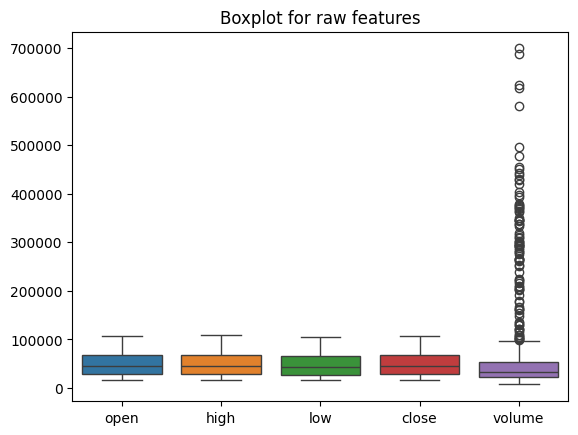

In [6]:
sns.boxplot(data = train[['open', 'high', 'low', 'close', 'volume']])
plt.title('Boxplot for raw features')
plt.show()

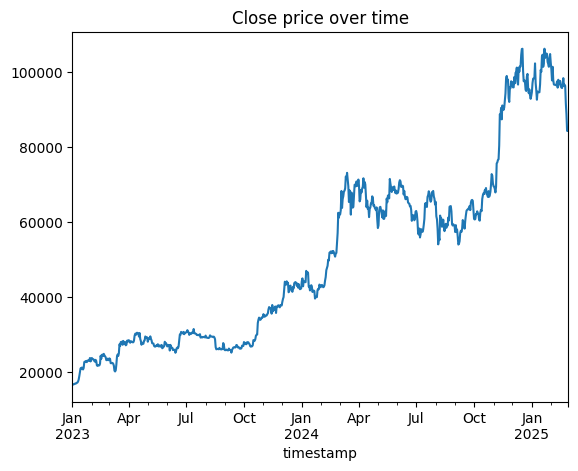

In [7]:
train.set_index('timestamp')['close'].plot()
plt.title('Close price over time')
plt.show()

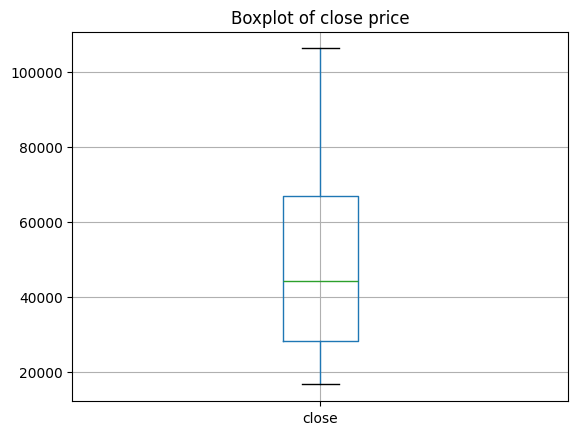

In [8]:
train[['close']].boxplot()
plt.title('Boxplot of close price')
plt.show()

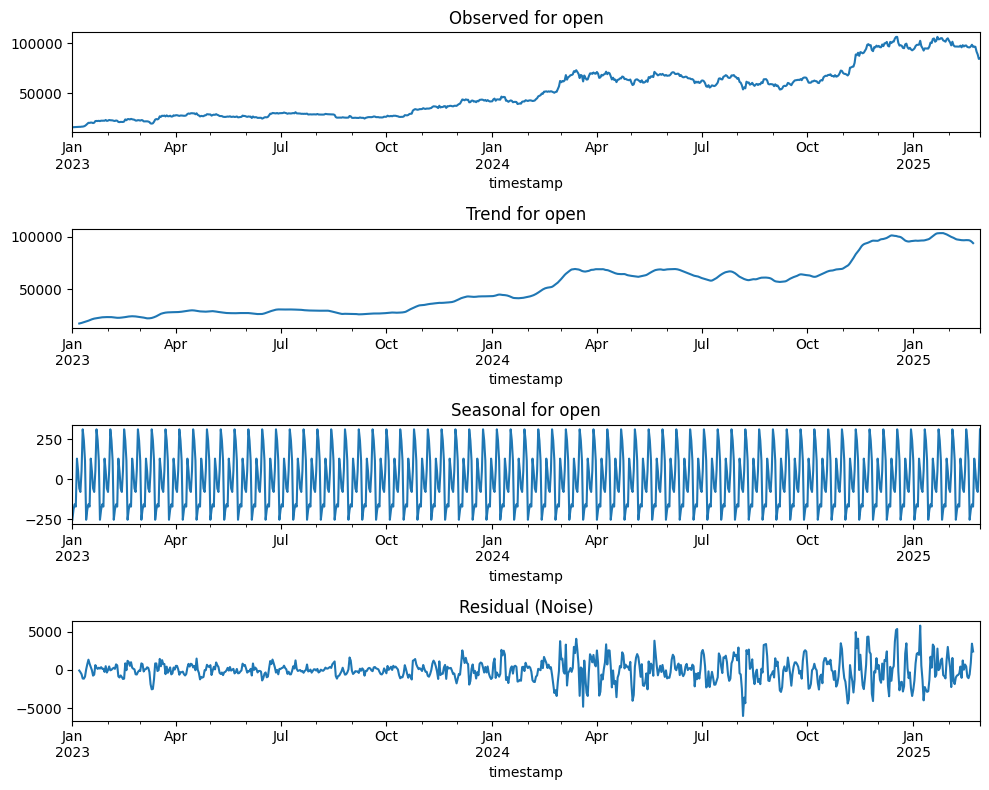

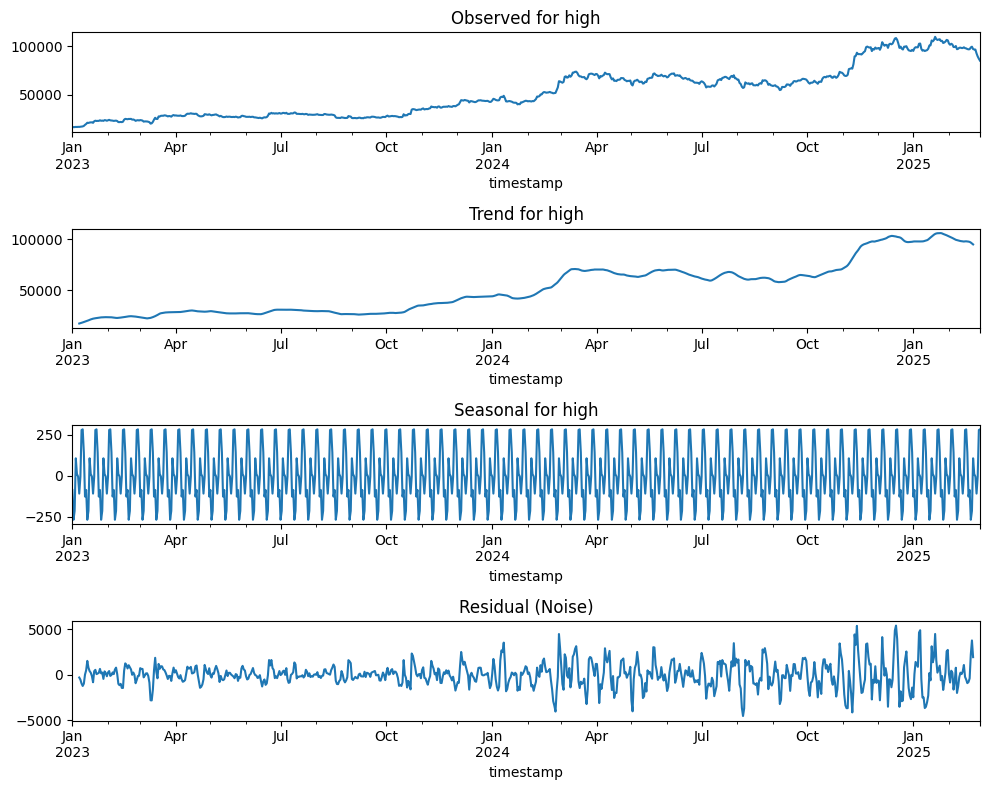

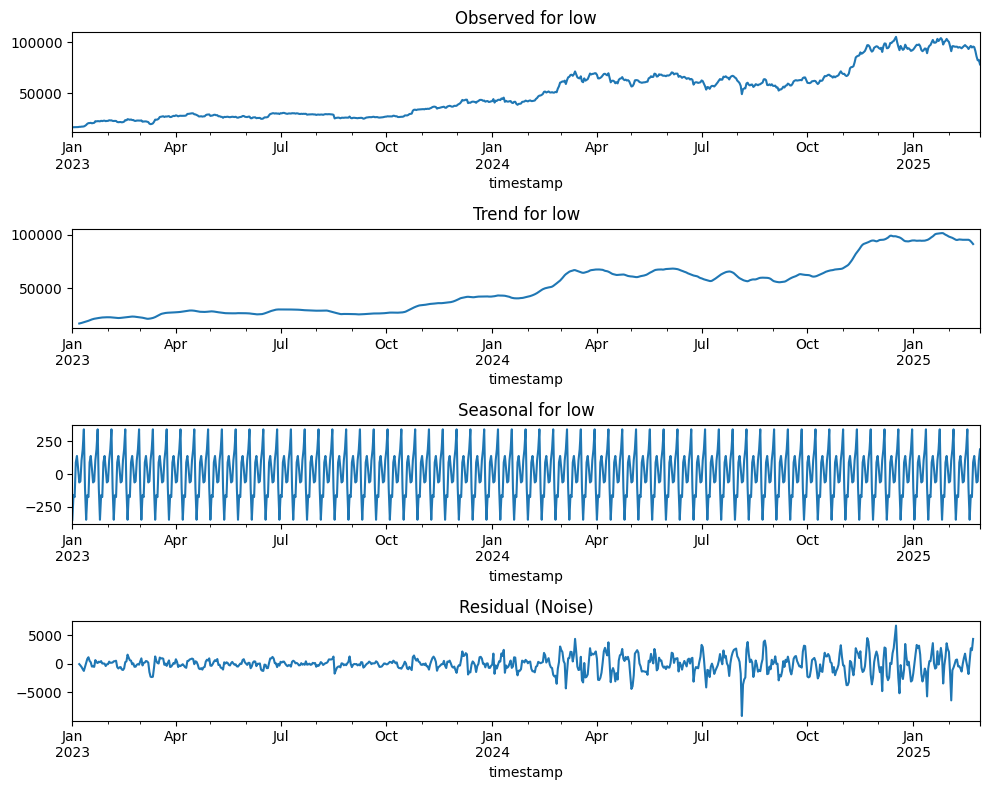

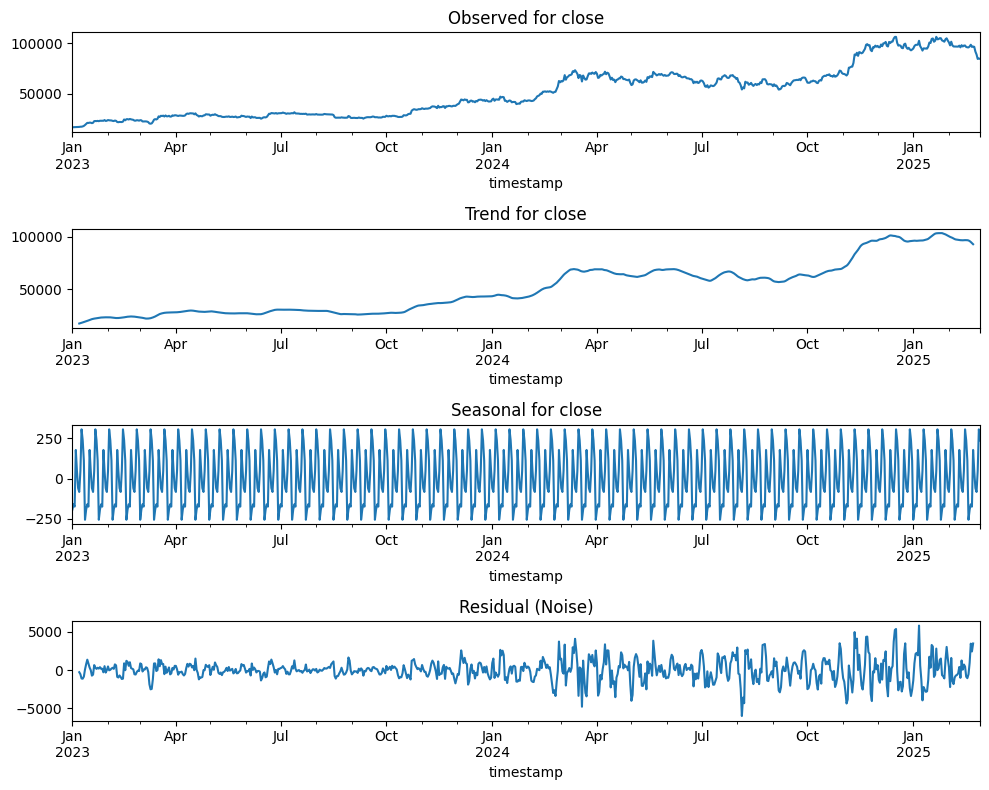

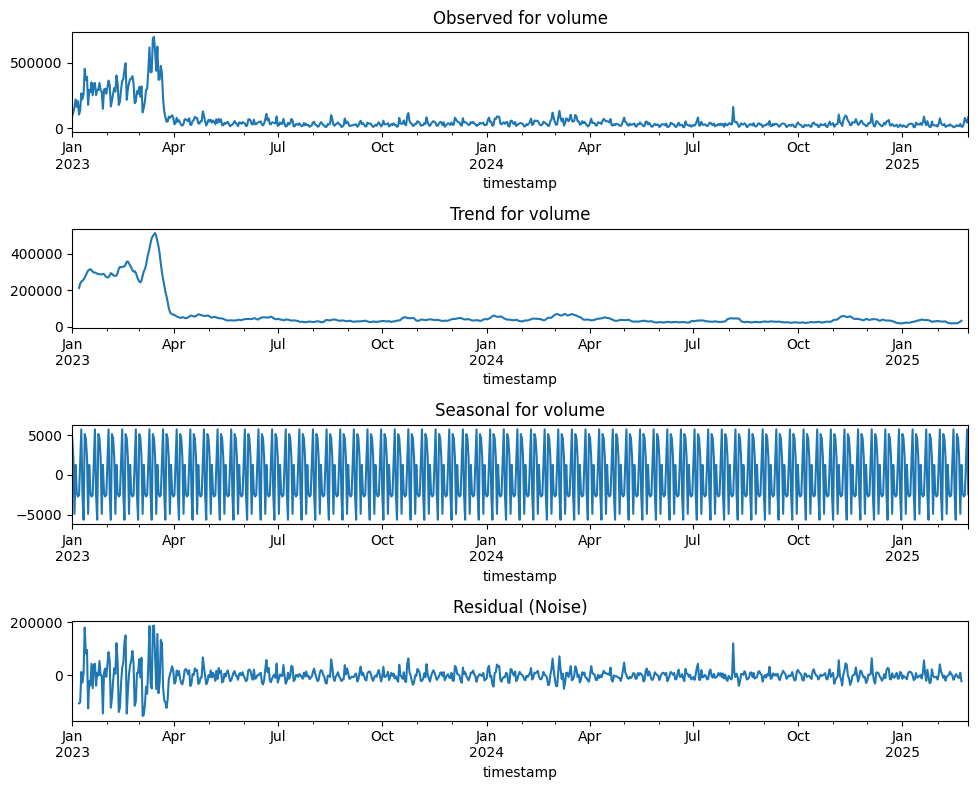

In [9]:
def seasonal_decompose_plot(df, feature):
    df_final = df.copy()
    if 'timestamp' in df_final.columns:
        df_final = df_final.set_index('timestamp')
    # assume yearly seasonality
    result = seasonal_decompose(df_final[feature], model = 'additive', period = 12)
    fig, axes = plt.subplots(4, 1, figsize = (10, 8))
    result.observed.plot(ax = axes[0], title = f'Observed for {feature}')
    result.trend.plot(ax = axes[1], title = f"Trend for {feature}")
    result.seasonal.plot(ax = axes[2], title = f"Seasonal for {feature}")
    result.resid.plot(ax = axes[3], title = f"Residual (Noise)")
    plt.tight_layout()
    plt.show()

for feature in train.columns[1:]:
    seasonal_decompose_plot(train, feature)

In [10]:
K = 3
def feature_engineer_dataset(df, k):
    df_final = df.copy()
    df_final['timestamp'] = pd.to_datetime(df_final['timestamp'])
    df_final.set_index('timestamp', inplace = True)
    df_final['next_day_close_price'] = df_final['close'].shift(-1).ffill()
    df_final['prev_day_close_price'] = df_final['close'].shift(1).bfill()
    df_final['price_range'] = df_final['high'] - df_final['low']
    df_final['open_close_diff'] = df_final['close'] - df_final['open']
    for feature in ['price_range', 'open_close_diff']:
        df_final[f'{feature}_7d_moving_avg'] = df_final[feature].rolling(window = 7, min_periods = 1).mean()
        df_final[f'{feature}_exp_moving_avg'] = df_final[feature].ewm(alpha = 0.5, min_periods = 1).mean()
        df_final[f'{feature}_7d_moving_stdev'] = df_final[feature].rolling(window = 7, min_periods = 1).std().bfill()
    df_final[f'close_{k}d_moving_avg'] = df_final['close'].rolling(window = k, min_periods = 1).mean()
    df_final[f'close_exp_moving_avg'] = df_final['close'].ewm(alpha = 0.5).mean()
    df_final['target'] = df_final['next_day_close_price'] - df_final[f'close_{k}d_moving_avg']
    df_final.drop(['volume', 'open', 'close', 'high', 'low', 'next_day_close_price'], axis = 1, inplace = True)
    return df_final

# Need back the close 3d moving average to transform back the prediction
def split_xy_close(df, k):
    return df.drop(['target', f'close_{k}d_moving_avg', 'close_exp_moving_avg'], axis = 1), df['target'], df[f'close_{k}d_moving_avg'], df['close_exp_moving_avg']

std_scaler = StandardScaler()
train_final = feature_engineer_dataset(train, K)
test_final = feature_engineer_dataset(test, K)
X_train, y_train, close_train, exp_train = split_xy_close(train_final, K)
X_test, y_test, close_test, exp_test = split_xy_close(test_final, K)
X_train_numpy = std_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_numpy, columns = X_train.columns)
X_test_numpy = std_scaler.transform(X_test)
X_test = pd.DataFrame(X_test_numpy, columns = X_test.columns)

In [11]:
def cross_val(model, X_train, y_train, close_train, exp_train):
    # TimeSeriesSplit setup
    tscv = TimeSeriesSplit(n_splits=3)
    mse_scores = []
    r2_scores = []

    mse_scores_moving_avg = []
    r2_scores_moving_avg = []

    mse_scores_exp_moving_avg = []
    r2_scores_exp_moving_avg = []
    for train_idx, test_idx in tscv.split(X_train):
        xTrain, xVal = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
        yTrain, yVal = y_train.iloc[train_idx], y_train.iloc[test_idx]
        closeTrain, closeVal = close_train.iloc[train_idx], close_train.iloc[test_idx]
        expTrain, expVal = exp_train.iloc[train_idx], exp_train.iloc[test_idx]

        model.fit(xTrain, yTrain)
        yPred = model.predict(xVal)
        price_actual = yVal + closeVal
        price_predicted = yPred + closeVal
        price_from_nd_moving_avg = closeVal
        price_predicted_from_ewm = expVal

        mse = mean_squared_error(price_actual, price_predicted)
        r2 = r2_score(price_actual, price_predicted)
        mse_scores.append(mse)
        r2_scores.append(r2)

        mse_moving_avg = mean_squared_error(price_actual, price_from_nd_moving_avg)
        r2_moving_avg = r2_score(price_actual, price_from_nd_moving_avg)
        mse_scores_moving_avg.append(mse_moving_avg)
        r2_scores_moving_avg.append(r2_moving_avg)

        mse_exp_moving_avg = mean_squared_error(price_actual, price_predicted_from_ewm)
        r2_exp_moving_avg = r2_score(price_actual, price_predicted_from_ewm)
        mse_scores_exp_moving_avg.append(mse_exp_moving_avg)
        r2_scores_exp_moving_avg.append(r2_exp_moving_avg)
        return [np.mean(mse_scores), np.mean(r2_scores), 
                np.mean(mse_scores_moving_avg), np.mean(r2_scores_moving_avg),
                np.mean(mse_scores_exp_moving_avg), np.mean(r2_scores_exp_moving_avg)]

xgb = XGBRegressor(random_state = 42)
rf = RandomForestRegressor(random_state = 42)
knn = KNeighborsRegressor()
lasso = Lasso(random_state = 42)

models = {'xgb': xgb
          , 'rf': rf
          , 'knn': knn
          , 'lasso': lasso}
res = []
for model_name, model in models.items():
    mse, r2, mse_moving_avg, r2_moving_avg, mse_exp_moving_avg, r2_exp_moving_avg = cross_val(model, X_train, y_train, close_train, exp_train)
    print(f'{model_name} has MSE of {mse} and R2 score of {r2} with ML')
    print(f'{model_name} has MSE of {mse_moving_avg} and R2 score of {r2_moving_avg} with just {K}d moving average')
    print(f'{model_name} has MSE of {mse_exp_moving_avg} and R2 score of {r2_exp_moving_avg} with just {K}d exponential moving average')

xgb has MSE of 839184.676898824 and R2 score of 0.9822300362429377 with ML
xgb has MSE of 917921.1063530182 and R2 score of 0.9805627709361736 with just 3d moving average
xgb has MSE of 803774.3240581385 and R2 score of 0.9829798600944993 with just 3d exponential moving average
rf has MSE of 730614.865575398 and R2 score of 0.9845290315242362 with ML
rf has MSE of 917921.1063530182 and R2 score of 0.9805627709361736 with just 3d moving average
rf has MSE of 803774.3240581385 and R2 score of 0.9829798600944993 with just 3d exponential moving average
knn has MSE of 776934.3185539204 and R2 score of 0.9835482045104292 with ML
knn has MSE of 917921.1063530182 and R2 score of 0.9805627709361736 with just 3d moving average
knn has MSE of 803774.3240581385 and R2 score of 0.9829798600944993 with just 3d exponential moving average
lasso has MSE of 720520.333339936 and R2 score of 0.9847427859896198 with ML
lasso has MSE of 917921.1063530182 and R2 score of 0.9805627709361736 with just 3d movin

In [12]:
def train_and_make_prediction(model, X_train, y_train, X_test, y_test, close_test, exp_test):
    # TimeSeriesSplit setup
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    price_actual = y_test + close_test
    price_predicted = y_pred + close_test
    price_from_nd_moving_avg = close_test
    price_predicted_from_ewm = exp_test

    mse = mean_squared_error(price_actual, price_predicted)
    r2 = r2_score(price_actual, price_predicted)
    mse_moving_avg = mean_squared_error(price_actual, price_from_nd_moving_avg)
    r2_moving_avg = r2_score(price_actual, price_from_nd_moving_avg)
    mse_exp_moving_avg = mean_squared_error(price_actual, price_predicted_from_ewm)
    r2_exp_moving_avg = r2_score(price_actual, price_predicted_from_ewm)
    return [model, y_pred, mse, r2, mse_moving_avg, r2_moving_avg, mse_exp_moving_avg, r2_exp_moving_avg]

res = {}
for model_name, model in models.items():
    trained_model, y_pred, mse, r2, mse_moving_avg, r2_moving_avg, mse_exp_moving_avg, r2_exp_moving_avg\
          = train_and_make_prediction(model, X_train, y_train, X_test, y_test, close_test, exp_test)
    res[model_name] = {'trained_model': trained_model,
                       'y_pred': y_pred,
                       'mse': mse,
                       'r2': r2,
                       'mse_moving_avg': mse_moving_avg,
                       'r2_moving_avg': r2_moving_avg,
                       'mse_exp_moving_avg': mse_exp_moving_avg,
                       'r2_exp_moving_avg': r2_exp_moving_avg}
    print(f'{model_name} has MSE of {mse} and R2 score of {r2} with ML')
    print(f'{model_name} has MSE of {mse_moving_avg} and R2 score of {r2_moving_avg} with just {K}d moving average')
    print(f'{model_name} has MSE of {mse_exp_moving_avg} and R2 score of {r2_exp_moving_avg} with just {K}d exponential moving average')
    print('\n')

xgb has MSE of 7261271.33289331 and R2 score of 0.24869903042782093 with ML
xgb has MSE of 8420329.566149555 and R2 score of 0.12877491046120682 with just 3d moving average
xgb has MSE of 8086287.128609648 and R2 score of 0.163337233737176 with just 3d exponential moving average


rf has MSE of 7945615.936394928 and R2 score of 0.17789204077530962 with ML
rf has MSE of 8420329.566149555 and R2 score of 0.12877491046120682 with just 3d moving average
rf has MSE of 8086287.128609648 and R2 score of 0.163337233737176 with just 3d exponential moving average


knn has MSE of 7836578.371597466 and R2 score of 0.18917381560460533 with ML
knn has MSE of 8420329.566149555 and R2 score of 0.12877491046120682 with just 3d moving average
knn has MSE of 8086287.128609648 and R2 score of 0.163337233737176 with just 3d exponential moving average


lasso has MSE of 9539561.34246538 and R2 score of 0.012971509077083554 with ML
lasso has MSE of 8420329.566149555 and R2 score of 0.12877491046120682 with 

In [13]:
def tune_and_evaluate_models(models, X_train, y_train, close_train, exp_train, 
                             X_test, y_test, close_test, exp_test, K, cv_splits=5):
    """
    Enhanced hyperparameter tuning with:
    - Proper custom scoring implementation
    - No early stopping conflicts
    - Feature importance analysis
    """

    # Parameter grids (optimized for time-series)
    param_grids = {
        'xgb': {
            'n_estimators': [100, 200, 300, 500], 
            'learning_rate': [0.005, 0.01, 0.05, 0.1],  
            'max_depth': [3, 5, 7, 9],
            'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3],  
            'min_child_weight': [1, 3, 5],  
            'reg_alpha': [0, 0.1, 1],  
            'reg_lambda': [0, 0.1, 1],  
            'max_bin': [64, 128, 256]  
        },
        'rf': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', 0.5, 0.8],
            'bootstrap': [True],
            'max_samples': [None, 0.7, 0.8],  
            'ccp_alpha': [0.0, 0.01, 0.1]  
        },
        'knn': {
            'n_neighbors': [3, 5, 7, 10, 15, 20],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree'],
            'leaf_size': [10, 20, 30, 50],
            'p': [1, 2, 3],  
            'metric': ['euclidean', 'manhattan', 'minkowski']
        },
        'lasso': {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
            'fit_intercept': [True, False],
            'selection': ['cyclic', 'random'],
            'tol': [1e-4, 1e-3, 1e-2],
            'max_iter': [1000, 2000, 5000]
        }
    }

    tscv = TimeSeriesSplit(n_splits=cv_splits)
    results = {} 
    best_models = {}

    for model_name, model in models.items():
        print(f"\n=== Tuning {model_name.upper()} ===")

        # Hyperparameter tuning
        opt = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[model_name],  
            n_iter=20, 
            cv=tscv,
            scoring='r2',  
            n_jobs=-1,
            random_state=42
        )

        opt.fit(X_train, y_train)
        best_model = opt.best_estimator_  # This is the tuned model
        print(f"Best params: {opt.best_params_}")

        y_pred = best_model.predict(X_test)
        price_actual = y_test + close_test
        price_predicted = y_pred + close_test
        price_from_nd_moving_avg = close_test
        price_predicted_from_ewm = exp_test

        mse = mean_squared_error(price_actual, price_predicted)
        r2 = r2_score(price_actual, price_predicted)
        mse_moving_avg = mean_squared_error(price_actual, price_from_nd_moving_avg)
        r2_moving_avg = r2_score(price_actual, price_from_nd_moving_avg)
        mse_exp_moving_avg = mean_squared_error(price_actual, price_predicted_from_ewm)
        r2_exp_moving_avg = r2_score(price_actual, price_predicted_from_ewm)

        results[model_name] = {'trained_model': best_model,
                    'y_pred': y_pred,
                    'mse': mse,
                    'r2': r2,
                    'mse_moving_avg': mse_moving_avg,
                    'r2_moving_avg': r2_moving_avg,
                    'mse_exp_moving_avg': mse_exp_moving_avg,
                    'r2_exp_moving_avg': r2_exp_moving_avg,
                    'price_actual': price_actual,
                    'price_predicted' : price_predicted,
                    'price_from_nd_moving_avg': price_from_nd_moving_avg,
                    'price_predicted_from_ewm': price_predicted_from_ewm
                    }

        print(f'{model_name} has MSE of {mse:.4f} and R2 score of {r2:.4f} with ML')
        print(f'{model_name} has MSE of {mse_moving_avg:.4f} and R2 score of {r2_moving_avg:.4f} with {K}d moving average')
        print(f'{model_name} has MSE of {mse_exp_moving_avg:.4f} and R2 score of {r2_exp_moving_avg:.4f} with {K}d exponential moving average')

        best_models[model_name] = best_model  
    return results, best_models


In [14]:
# 1. First get baseline performance with default parameters
print("=== Baseline Model Performance ===")
baseline_results = {}
for model_name, model in models.items():
    trained_model, y_pred, mse, r2, mse_moving_avg, r2_moving_avg, mse_exp_moving_avg, r2_exp_moving_avg\
          = train_and_make_prediction(model, X_train, y_train, X_test, y_test, close_test, exp_test)
    baseline_results[model_name] = {
        'mse': mse,
        'r2': r2,
        'mse_moving_avg': mse_moving_avg,
        'r2_moving_avg': r2_moving_avg,
        'mse_exp_moving_avg': mse_exp_moving_avg,
        'r2_exp_moving_avg': r2_exp_moving_avg
    }
    print(f"{model_name} Baseline - MSE w ML: {mse:.4f}, R2: {r2:.4f}")
    print(f"{model_name} Baseline - MSE w moving average: {mse_moving_avg:.4f}, R2: {r2_moving_avg:.4f}")
    print(f"{model_name} Baseline - MSE w exponential moving average: {mse_exp_moving_avg:.4f}, R2: {r2_exp_moving_avg:.4f}")

# 2. Run the enhanced tuning
results, best_models = tune_and_evaluate_models(
    models, X_train, y_train, close_train, exp_train,
    X_test, y_test, close_test, exp_test, K
)


=== Baseline Model Performance ===
xgb Baseline - MSE w ML: 7261271.3329, R2: 0.2487
xgb Baseline - MSE w moving average: 8420329.5661, R2: 0.1288
xgb Baseline - MSE w exponential moving average: 8086287.1286, R2: 0.1633
rf Baseline - MSE w ML: 7945615.9364, R2: 0.1779
rf Baseline - MSE w moving average: 8420329.5661, R2: 0.1288
rf Baseline - MSE w exponential moving average: 8086287.1286, R2: 0.1633
knn Baseline - MSE w ML: 7836578.3716, R2: 0.1892
knn Baseline - MSE w moving average: 8420329.5661, R2: 0.1288
knn Baseline - MSE w exponential moving average: 8086287.1286, R2: 0.1633
lasso Baseline - MSE w ML: 9539561.3425, R2: 0.0130
lasso Baseline - MSE w moving average: 8420329.5661, R2: 0.1288
lasso Baseline - MSE w exponential moving average: 8086287.1286, R2: 0.1633

=== Tuning XGB ===
Best params: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'max_bin': 64, 'learning_rate': 0.005, 'gamma': 0.2, 'colsample_bytree'

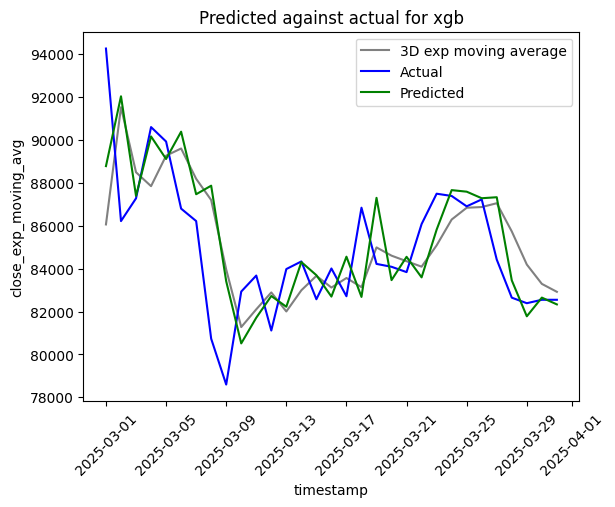

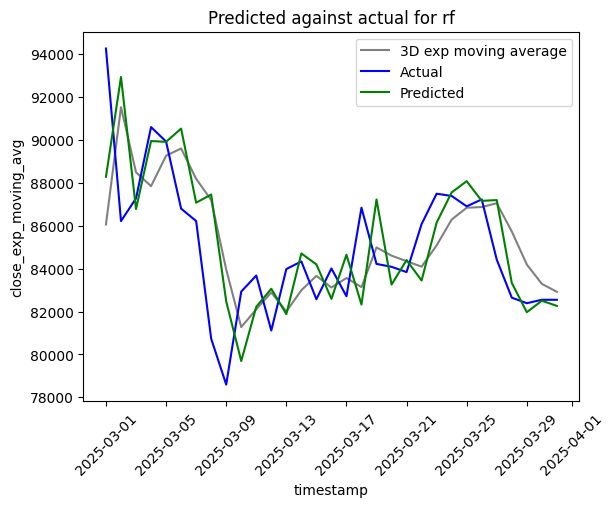

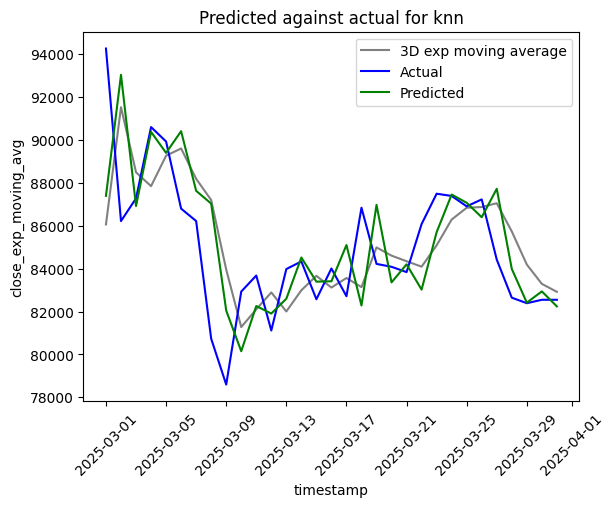

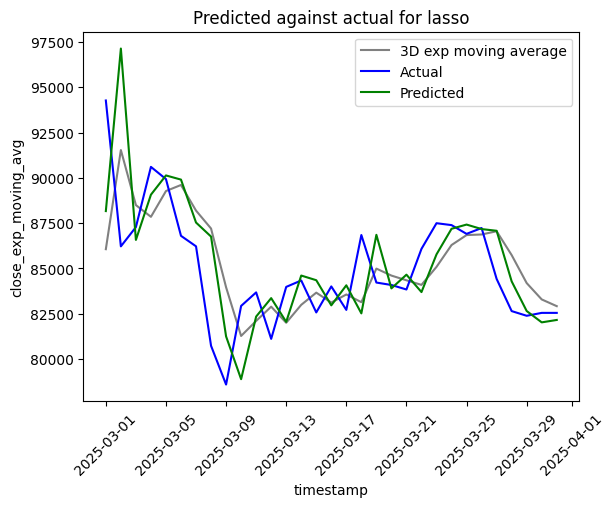

In [15]:
def plot_actual_against_predicted_test(model_name, y_test, y_pred):
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    sns.lineplot(data = y_test, label='Actual', color = 'blue')
    sns.lineplot(data = y_pred_series, label='Predicted', color = 'green')
    plt.legend()
    plt.title(f'Predicted against actual for {model_name}')
    plt.xticks(rotation = 45)
    plt.show()

close_test_series = pd.Series(close_test, index = close_test.index)
exp_test_series = pd.Series(exp_test, index = exp_test.index)
for model_name, d in results.items():
    #sns.lineplot(data = close_test_series, label = '3D moving average', color = 'black')
    sns.lineplot(data = exp_test_series, label = '3D exp moving average', color = 'grey')
    plot_actual_against_predicted_test(model_name, y_test + close_test, d['y_pred'] + close_test)


In [20]:
# 1. Find the model with the highest R² score from the baseline results
best_baseline_model = max(baseline_results, key=lambda model: baseline_results[model]['r2'])

print(f"Best Model with Highest R² (Baseline): {best_baseline_model}")
print(f"R² Score: {baseline_results[best_baseline_model]['r2']:.4f}")

# 2. Find the model with the highest R² score from the enhanced tuning results
best_tuned_model = max(results, key=lambda model: results[model]['r2'])

print(f"Best Model with Highest R² (After Tuning): {best_tuned_model}")
print(f"R² Score: {results[best_tuned_model]['r2']:.4f}")


combined_df = test_final.copy()
combined_df = combined_df.rename(columns={'target':'actual_deviation'})
combined_df['next_day_close_price_actual'] = results[best_tuned_model]['price_actual']
combined_df['next_day_close_price_predicted'] = results[best_tuned_model]['price_predicted']
combined_df['price_from_nd_moving_avg'] = results[best_tuned_model]['price_from_nd_moving_avg']
combined_df['price_predicted_from_ewm'] = results[best_tuned_model]['price_predicted_from_ewm']
combined_df['predicted_deviation'] = results[best_tuned_model]['y_pred']

print(combined_df.head())
print(combined_df.info())
print(combined_df.describe())


Best Model with Highest R² (Baseline): xgb
R² Score: 0.2487
Best Model with Highest R² (After Tuning): xgb
R² Score: 0.2589
            prev_day_close_price  price_range  open_close_diff  \
timestamp                                                        
2025-03-01              86064.53      2733.22          1714.58   
2025-03-02              86064.53      9949.40          8205.46   
2025-03-03              94270.00      9299.35         -8049.38   
2025-03-04              86220.61      7467.52          1060.82   
2025-03-05              87281.98      4665.47          3324.03   

            price_range_7d_moving_avg  price_range_exp_moving_avg  \
timestamp                                                           
2025-03-01                2733.220000                 2733.220000   
2025-03-02                6341.310000                 7544.006667   
2025-03-03                7327.323333                 8547.060000   
2025-03-04                7362.372500                 7971.305333   